In [1]:
!git clone https://github.com/fastai/course22p2.git

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1176 (delta 319), reused 294 (delta 294), pack-reused 795 (from 1)
Receiving objects: 100% (1176/1176), 98.57 MiB | 36.28 MiB/s, done.
Resolving deltas: 100% (714/714), done.


In [2]:
%cd course22p2/

/kaggle/working/course22p2


In [3]:
!pip install -e .

Obtaining file:///kaggle/working/course22p2
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 120.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 100.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━

In [4]:
!pip install datasets

In [5]:
!pip install \
    fsspec==2023.9.0 \
    numpy==1.26.4 \
    torchaudio==2.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 88.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.10.0
    Uninstalling fsspec-2025.10.0:
      Successfully uninstalled fsspec-2025.10.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling torchaudio-2.6.0+cu124:
      Successfully uninstalled torchaudio-2.6.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
s3fs 2025.3.0 requires fsspec==2025.3.0.*, but you have fsspec 2023.9.0 which is i

**Data Loading******

In [7]:
import os, pathlib
import numpy as np
import pandas as pd

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [9]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

In [10]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [11]:
from fastcore.all import *

In [12]:
from torch.utils.data import default_collate
from operator import itemgetter

In [13]:
from datasets import load_dataset,load_dataset_builder

In [14]:
from torch.nn import init

In [15]:
from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *
from copy import copy
from collections.abc import Mapping

In [16]:
from torcheval.metrics import MulticlassAccuracy,Mean
from operator import attrgetter
from functools import partial

In [17]:
from torchvision import transforms

In [18]:
from datasets import Image, Features, Value, Dataset, DatasetDict

## Load in the dataset

In [24]:
out_dir = Path('/kaggle/input/preprocessed128/preprocessed_128')

In [25]:
import pandas as pd
df = pd.read_csv('/kaggle/input/treemetadatacsv/tree_metadata_dev.csv')
print(f"Loaded metadata for {len(df)} trees from CSV.")

Loaded metadata for 17707 trees from CSV.


In [26]:
def generate_examples():

    for _, row in df.iterrows():
        tree_id_int = row['treeID']
        image_id_str = f"{tree_id_int:05d}"
        facade_path = out_dir / f"{image_id_str}_facade.png"
        nadir_path = out_dir / f"{image_id_str}_nadir.png"
        profile_path = out_dir / f"{image_id_str}_profile.png"
        rear_path = out_dir / f"{image_id_str}_rear.png"
        if facade_path.exists() and nadir_path.exists() and profile_path.exists() and rear_path.exists():
            yield {
                'id': image_id_str,
                'facade_image': str(facade_path),
                'nadir_image': str(nadir_path),
                'profile_image': str(profile_path),
                'rear_image': str(rear_path),
                'species': row['species'],
            }

In [27]:
features = Features({
    'id': Value('string'),
    'facade_image': Image(),
    'nadir_image': Image(),
    'profile_image': Image(),
    'rear_image': Image(), 
    'species': Value('string'),
})


In [28]:
full_dataset = Dataset.from_generator(
    generate_examples,
    features=features,
)

Generating train split: 0 examples [00:00, ? examples/s]

In [29]:
print("\nFull dataset created successfully:")
print(full_dataset)


Full dataset created successfully:
Dataset({
    features: ['id', 'facade_image', 'nadir_image', 'profile_image', 'rear_image', 'species'],
    num_rows: 16257
})


In [30]:
dsd = full_dataset.train_test_split(test_size=64, seed=42)
dsd['valid'] = dsd.pop('test')

In [31]:
print(dsd)

DatasetDict({
    train: Dataset({
        features: ['id', 'facade_image', 'nadir_image', 'profile_image', 'rear_image', 'species'],
        num_rows: 16193
    })
    valid: Dataset({
        features: ['id', 'facade_image', 'nadir_image', 'profile_image', 'rear_image', 'species'],
        num_rows: 64
    })
})


In [32]:

unique_species = sorted(dsd['train'].unique('species')) 
species_to_idx = {species: i for i, species in enumerate(unique_species)}
num_species = len(unique_species)

print(f"Found {num_species} unique species.")
print("Species to ID mapping:", species_to_idx)

Flattening the indices:   0%|          | 0/16193 [00:00<?, ? examples/s]

Found 33 unique species.
Species to ID mapping: {'Abies_alba': 0, 'Acer_campestre': 1, 'Acer_pseudoplatanus': 2, 'Acer_saccharum': 3, 'Betula_pendula': 4, 'Carpinus_betulus': 5, 'Corylus_avellana': 6, 'Crataegus_monogyna': 7, 'Eucalyptus_miniata': 8, 'Euonymus_europaeus': 9, 'Fagus_sylvatica': 10, 'Fraxinus_angustifolia': 11, 'Fraxinus_excelsior': 12, 'Larix_decidua': 13, 'Picea_abies': 14, 'Picea_glauca': 15, 'Pinus_contorta': 16, 'Pinus_nigra': 17, 'Pinus_pinaster': 18, 'Pinus_radiata': 19, 'Pinus_resinosa': 20, 'Pinus_sylvestris': 21, 'Populus_deltoides': 22, 'Populus_tremuloides': 23, 'Prunus_avium': 24, 'Pseudotsuga_menziesii': 25, 'Quercus_faginea': 26, 'Quercus_ilex': 27, 'Quercus_petraea': 28, 'Quercus_robur': 29, 'Quercus_rubra': 30, 'Tilia_cordata': 31, 'Ulmus_laevis': 32}


In [33]:
bs = 64

In [34]:
facade = 'facade_image'
nadir = 'nadir_image'
profile = 'profile_image'
rear = 'rear_image'
species = 'species'


## DataLoading

create a dataloader where an item in a batch consists of 2 variables x(input) and y(label) x should contain 2 images (facade and nadir) and Y should consist of label

In [35]:
def collate_fn(batch):

    
    images = []
    labels = []
    
    for grid, label in batch:        
        images.append(grid)
        labels.append(label)
    
    return torch.stack(images), torch.tensor(labels)

## Augmentation


In [36]:
xmean,xstd = (tensor(0.10),tensor(0.21))


In [37]:
train_ds = dsd['train']
valid_ds = dsd['valid']

In [38]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image

class TfmDS:
    def __init__(self, ds, tfmy, aug): 
        self.ds = ds
        self.is_train = aug
        self.tfmy = tfmy
        
        self.nadir_aug = T.Compose([
            T.RandomRotation(180),
            T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ])
        
        self.side_aug = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ])
        
        self.combined_aug = T.Compose([
            T.TrivialAugmentWide(),
            T.Pad(4),
            T.RandomCrop(256)
        ])

        self.norm = T.Normalize(xmean, xstd)
        self.to_tensor = T.ToTensor()
        self.randerase = RandErase()

    def __len__(self): 
        return len(self.ds)
        
    def __getitem__(self, i):
        item = self.ds[i]
        
        img_facade = (item['facade_image']).convert('L')
        img_nadir = (item['nadir_image']).convert('L')
        img_profile = (item['profile_image']).convert('L')
        img_rear = (item['rear_image']).convert('L')

        if self.is_train:
            img_nadir = self.nadir_aug(img_nadir)
            img_facade = self.side_aug(img_facade)
            img_profile = self.side_aug(img_profile)
            img_rear = self.side_aug(img_rear)

        t_facade = self.to_tensor(img_facade)
        t_nadir = self.to_tensor(img_nadir)
        t_profile = self.to_tensor(img_profile)
        t_rear = self.to_tensor(img_rear)

        top_row = torch.cat([t_nadir, t_facade], dim=2) 
        bottom_row = torch.cat([t_rear, t_profile], dim=2)  
        grid = torch.cat([top_row, bottom_row], dim=1) 

        transform = T.ToPILImage()
        grid_pil = transform(grid)

        if self.is_train:
            grid_rgb = (grid_pil).convert('RGB')
            aug_grid = self.combined_aug(grid_rgb)
            grid_gray = (aug_grid).convert('L')       
            final_tensor = self.to_tensor(grid_gray)
        else:
            grid_gray = (grid_pil).convert('L')       
            final_tensor = self.to_tensor(grid_gray)

        final_tensor = self.norm(final_tensor)
        
        if self.is_train:
            final_tensor = self.randerase(final_tensor[None])[0]

        label = item['species']
        
        return final_tensor, self.tfmy(label)

In [39]:
tfm_train_ds = TfmDS(train_ds, species_to_idx.get,aug=True)
tfm_valid_ds = TfmDS(valid_ds, species_to_idx.get,aug=False)


In [40]:
train_dl = DataLoader(tfm_train_ds, batch_size=bs, 
                      collate_fn=collate_fn, num_workers=4, shuffle=True, drop_last=True)
valid_dl = DataLoader(tfm_valid_ds, batch_size=bs,  
                      collate_fn=collate_fn, num_workers=4)

In [41]:
dls = DataLoaders(train_dl, valid_dl)

dt = dls.train
xb, yb = next(iter(dt))
print(xb.shape, yb.shape)

torch.Size([64, 1, 256, 256]) torch.Size([64])


In [42]:
print(xb.mean(), xb.std() )

tensor(-0.01) tensor(1.00)


In [43]:
 idx_to_species = {v: k for k, v in species_to_idx.items()}

In [44]:
titles = [idx_to_species[label.item()] for label in yb[:16]]

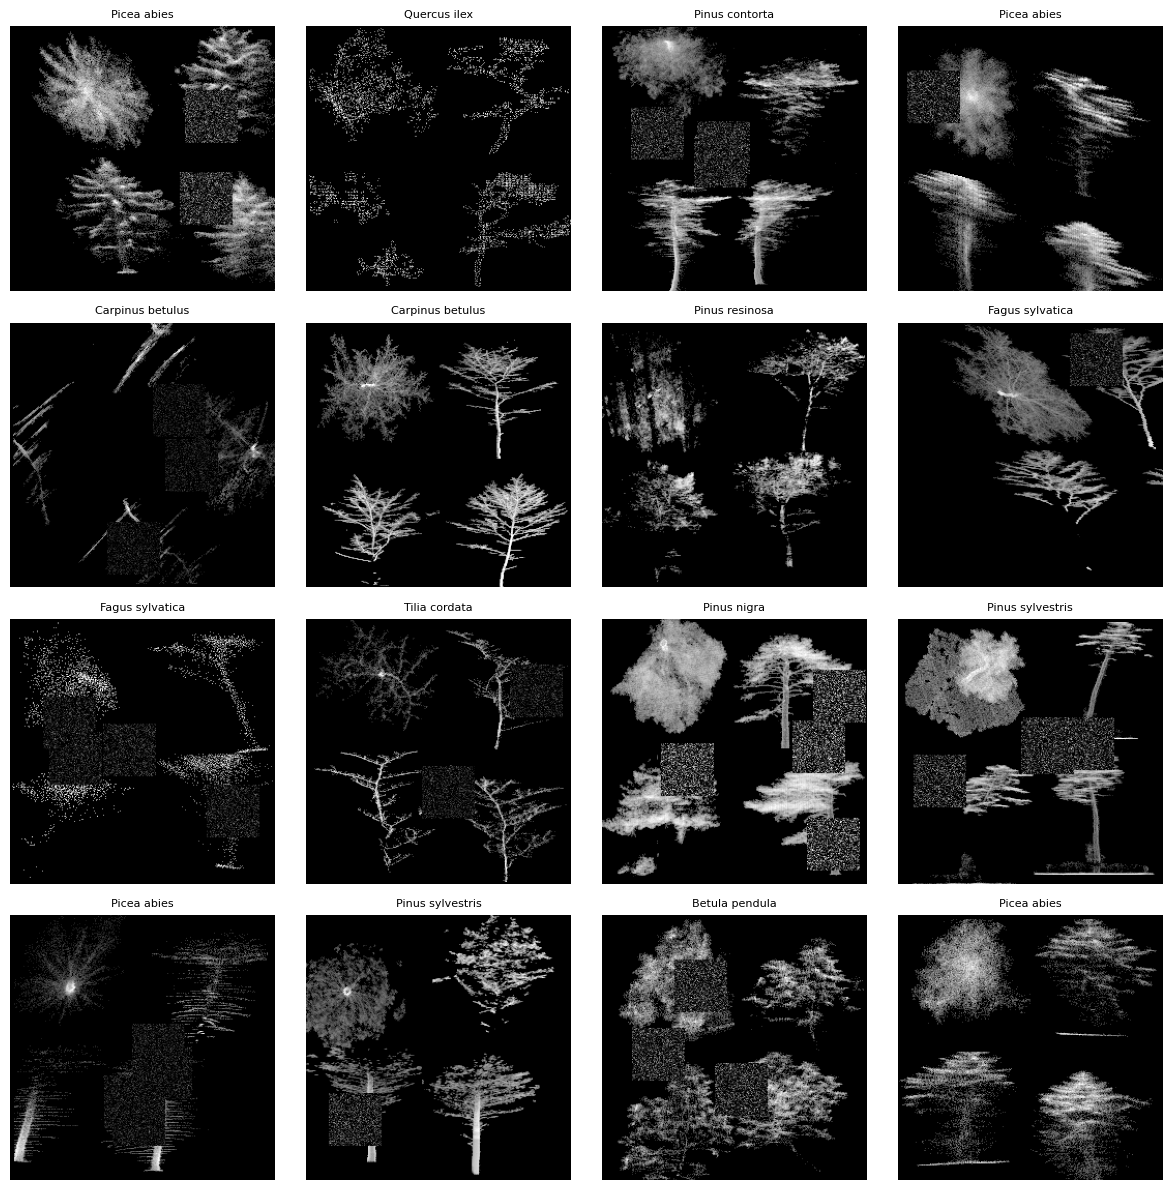

In [45]:
# Simple 4x4 grid visualization
def show_images(imgs, imsize=1.7, titles=None):
    fig, axes = plt.subplots(4, 4, figsize=(imsize*4, imsize*4))
    axes = axes.flatten()
    
    for i in range(16):
        if i < len(imgs):
            axes[i].imshow(imgs[i].squeeze(), cmap='gray')
            if titles and i < len(titles):
                axes[i].set_title(titles[i].replace('_', ' '), fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Use it
mpl.rcParams['figure.dpi'] = 100
show_images(xb[:16], imsize=3.0, titles=titles)

# Training the Dataset

In [19]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
iw = partial(init_weights, leaky=0.1)

## Identity Mapped Resnets

In [20]:
def conv(ni, nf, ks=3, stride=1, act=nn.ReLU, norm=None, bias=True):
    layers = []
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return nn.Sequential(*layers)

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1     , act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=act, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None, norm=norm)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return self.convs(x) + self.idconv(self.pool(x))

def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])
    
def get_dropmodel(act=act_gr, nfs=(16,32,64,128,256,512), nbks=(2,2,2,2,2), norm=nn.BatchNorm2d, drop=0.2):
    # Changed input channels from 3 to 1
    layers = [nn.Conv2d(1, nfs[0], 5, padding=2)]
    
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    
    layers += [act(), norm(nfs[-1]), nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    

    layers += [nn.Linear(nfs[-1], 33, bias=False), nn.BatchNorm1d(33)]
    
    return nn.Sequential(*layers).apply(iw)

In [21]:
def get_model():
    return get_dropmodel(
        # Increase width: 16 -> 512
        nfs=(16, 32, 64, 128, 256, 512), 
        # Moderate depth per stage
        nbks=(2, 2, 2, 2, 2), 
        drop=0.1
    )

In [46]:
lr, epochs = 2e-2, 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model().apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.311,2.557,0,train
0.516,1.608,0,eval
0.448,1.886,1,train
0.641,1.113,1,eval


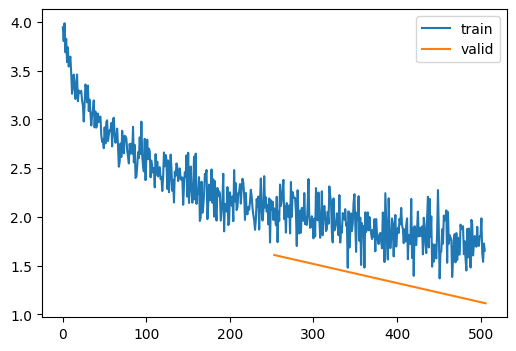

In [47]:
learn.fit(epochs)